### 렙톤 , 젯 , 팻젯 순으로 클리닝 하기
##### 렙톤이 젯이나 팻젯 안에 들어가냐 , 그리고 렙톤이 젯 팻젯으로 보이냐 그 두개로 생각해야함. 
##### 내 아날리시스 의 경우 들어가는건 걱정 안 해도 됨.
##### 근데 문제가 렙톤이 젯이나 팻젯으로 보이는 경우도 있고 다른 젯이나 팻젯 안에 렙톤이 들어가는 경우가 있으면 빼야함 
#### 추가로 bjet안에 다른 topjet 이 겹치는 경우 있으면 빼야함

In [4]:

from importlib import import_module
import os
import sys
import argparse
import linecache
import uproot
import vector
import math
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
from tqdm import tqdm  # ✅ 진행률 표시
import glob

vector.register_awkward()

# 모든 .root 파일 경로 가져오기
path = "/data6/Users/achihwan/LRSM_tb_channel/SAMPLEPRODUCTION/WRtoNMutoMuMuTB-HadTop_MWR-5000_MN-4900_13p6TeV/"
file_list = sorted(glob.glob(path + "*.root"))

cleaned_Nmother_muon_pt = []
cleaned_WR_mother_muon_pt = []
all_muon_pt = []

cleaned_ak4jet_pt = []
all_ak4jet_pt = []

cleaned_ak8jet_pt = []
all_ak8jet_pt = []

def overlap_removal(target, cleans, cut=0.4, dphi=False):
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return target[mask]

def find_closest_jet(obj, jets):
    # obj, jets: both are jagged arrays of shape (n_events,), each sublist = Momentum4D
    pairs = ak.cartesian([obj, jets], nested=True)          # shape: (n_events, N_obj, N_jet)
    dr = pairs["0"].deltaR(pairs["1"])                       # same shape
    # 이벤트별로 obj 하나당 가장 작은 ΔR 의 jet index
    closest_idx_per_obj = ak.argmin(dr, axis=2)              # shape = (n_events, N_obj)
    return jets[closest_idx_per_obj]





# tqdm으로 파일 리스트 순회
for sample in tqdm(file_list, desc="Processing ROOT files"):
    file = uproot.open(sample)
    events = file["Events"]

    keys = events.keys()

    vector.register_awkward()  

    lhe_pdgid = events["LHEPart_pdgId"].array()
    lhe_pt = events["LHEPart_pt"].array()
    lhe_eta = events["LHEPart_eta"].array()
    lhe_phi = events["LHEPart_phi"].array()
    lhe_mass = events["LHEPart_mass"].array()
    lhe_status = events["LHEPart_status"].array()

    ak4_eta = events["Jet_eta"].array()
    ak4_phi = events["Jet_phi"].array()
    ak4_pt = events["Jet_pt"].array()
    ak4_flavor = events["Jet_hadronFlavour"].array()
    ak4_mass = events["Jet_mass"].array()
    btag = events["Jet_btagPNetB"].array()

    ## Fatjet 
    fatjet_pt = events["FatJet_pt"].array()
    fatjet_eta = events["FatJet_eta"].array()
    fatjet_phi = events["FatJet_phi"].array()
    fatjet_mass = events["FatJet_mass"].array()

    gen_pdgid = events["GenPart_pdgId"].array()
    gen_pt = events["GenPart_pt"].array()
    gen_eta = events["GenPart_eta"].array()
    gen_phi = events["GenPart_phi"].array()
    gen_mass = events["GenPart_mass"].array()

    reco_muon_pt = events["Muon_pt"].array()
    reco_muon_eta = events["Muon_eta"].array()
    reco_muon_phi = events["Muon_phi"].array()
    reco_muon_mass = events["Muon_mass"].array()



    # mask 
    bottom_mask = (lhe_pdgid == 5) | (lhe_pdgid == -5)
    bottom_eta = lhe_eta[bottom_mask]
    bottom_phi = lhe_phi[bottom_mask]
    bottom_pt = lhe_pt[bottom_mask]
    bottom_mass = lhe_mass[bottom_mask]

    topmask = (gen_pdgid == 6) | (gen_pdgid == -6)
    top_eta = gen_eta[topmask]
    top_eta = top_eta[:, 0:1]  # top quark 1 = WR* mother
    top_phi = gen_phi[topmask]
    top_phi = top_phi[:, 0:1]
    top_pt = gen_pt[topmask]
    top_pt = top_pt[:, 0:1]  # top quark 1 = WR* mother
    top_mass = gen_mass[topmask]
    top_mass = top_mass[:, 0:1]  # top quark 1 = WR* mother

    bottompt = bottom_pt[:, 1:2]#bottom quark 1 = WR* mother
    bottometa = bottom_eta[:, 1:2]
    bottomphi = bottom_phi[:, 1:2]
    bottommass = bottom_mass[:, 1:2]

    muon_mask = (lhe_pdgid == 13) | (lhe_pdgid == -13)
    muon_pt = lhe_pt[muon_mask]
    muon_eta = lhe_eta[muon_mask]
    muon_phi = lhe_phi[muon_mask]
    muon_mass = lhe_mass[muon_mask]

    reco_muon_pt = reco_muon_pt[:]
    reco_muon_eta = reco_muon_eta[:]
    reco_muon_phi = reco_muon_phi[:]
    reco_muon_mass = reco_muon_mass[:] 


    n_mother_muon_mass = muon_mass[:,0:1] # muon 1 = WR* mother
    n_mother_muon_pt = muon_pt[:,0:1] # muon 1 = WR* mother
    n_mother_muon_eta = muon_eta[:,0:1]
    n_mother_muon_phi = muon_phi[:,0:1]

    WR_mother_muon_mass = muon_mass[:,1:2] # muon 2 = WR* mother
    WR_mother_muon_pt = muon_pt[:,1:2] # muon 2 = WR* mother
    WR_mother_muon_eta = muon_eta[:,1:2]
    WR_mother_muon_phi = muon_phi[:,1:2]  


    lhe_muons = ak.zip({
        "pt": muon_pt,
        "eta": muon_eta,
        "phi": muon_phi,
        "mass": muon_mass
    }, with_name = "Momentum4D")

    n_mother_muon = ak.zip({
        "pt": n_mother_muon_pt,
        "eta": n_mother_muon_eta,
        "phi": n_mother_muon_phi,
        "mass": n_mother_muon_mass
    }, with_name = "Momentum4D")

    WR_mother_muon = ak.zip({
        "pt": WR_mother_muon_pt,
        "eta": WR_mother_muon_eta,
        "phi": WR_mother_muon_phi,
        "mass": WR_mother_muon_mass
    }, with_name = "Momentum4D")

    reco_muons = ak.zip({
        "pt": reco_muon_pt,
        "eta": reco_muon_eta,
        "phi": reco_muon_phi,
        "mass": reco_muon_mass
    }, with_name = "Momentum4D")

    ak4 = ak.zip({
        "pt": ak4_pt,
        "eta": ak4_eta,
        "phi": ak4_phi,
        "mass": ak4_mass
    }, with_name = "Momentum4D")

    lhe_bottom = ak.zip({ ## bottom quark 1 = WR* mother
        "pt": bottompt,
        "eta": bottometa,
        "phi": bottomphi,
        "mass": bottommass
    }, with_name = "Momentum4D")

    gen_top = ak.zip({
        "eta": top_eta,
        "phi": top_phi,
        "pt": top_pt,
        "mass": top_mass
    }, with_name = "Momentum4D")

    fatjets = ak.zip({
        "pt": fatjet_pt,
        "eta": fatjet_eta,
        "phi": fatjet_phi,
        "mass": fatjet_mass
    }, with_name="Momentum4D")

    

    ak8jet = find_closest_jet(gen_top, fatjets)
    ak4jet = find_closest_jet(lhe_bottom, ak4)
    nmother_muon = find_closest_jet(n_mother_muon, reco_muons)
    wrmother_muon = find_closest_jet(WR_mother_muon, reco_muons)
    all_mother_muon = find_closest_jet(lhe_muons, reco_muons)
    ## 1. 뮤온은 자기 자신끼리만 안 겹치면 그대로 사용
    overlap_nmother_cleaned = overlap_removal(nmother_muon, [reco_muons]) #lepton lepton cleaning
    overlap_WR_mother_cleaned = overlap_removal(wrmother_muon, [reco_muons]) #lepton lepton cleaning

    cleaned_Nmother_muon_pt.append(overlap_nmother_cleaned["pt"])
    cleaned_WR_mother_muon_pt.append(overlap_WR_mother_cleaned["pt"])
    all_muon_pt.append(lhe_muons["pt"])
    # 2. b jet은 뮤온이랑만 안 겹치면 그대로 사용 
    overlap_ak4_cleaned = overlap_removal(ak4jet, [all_mother_muon, ak4])
    

    cleaned_ak4jet_pt.append(overlap_ak4_cleaned["pt"])
    all_ak4jet_pt.append(ak4jet["pt"])
    # 3. fatjet은 뮤온이랑 b jet이랑 안 겹쳐야 사용
    overlap_fatjet_cleaned = overlap_removal(ak8jet, [all_mother_muon , ak4 ,fatjets], cut=0.8)

    cleaned_ak8jet_pt.append(overlap_fatjet_cleaned["pt"])
    all_ak8jet_pt.append(fatjets["pt"])


    
    
    






Processing ROOT files:   0%|          | 0/80 [00:00<?, ?it/s]

Processing ROOT files: 100%|██████████| 80/80 [01:51<00:00,  1.39s/it]


In [5]:
print(len((ak.flatten(ak.flatten(cleaned_Nmother_muon_pt)))))
print(len((ak.flatten(ak.flatten(cleaned_WR_mother_muon_pt)))))
print(len((ak.flatten(ak.flatten(all_muon_pt)))))
print(len((ak.flatten(ak.flatten(cleaned_ak8jet_pt)))))
print(len((ak.flatten(ak.flatten(all_ak8jet_pt)))))
print(len((ak.flatten(ak.flatten(cleaned_ak4jet_pt)))))
print(len((ak.flatten(ak.flatten(all_ak4jet_pt)))))

37064
36206
80000
123
146738
37668
40000


In [15]:

from importlib import import_module
import os
import sys
import argparse
import linecache
import uproot
import vector
import math
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
from tqdm import tqdm  # ✅ 진행률 표시
import glob

vector.register_awkward()

sample = "/data6/Users/achihwan/LRSM_tb_channel/SAMPLEPRODUCTION/WRtoNMutoMuMuTB-HadTop_MWR-5000_MN-2500_13p6TeV/Run3Summer22NanoAODv12_WRtoNMutoMuMuTB-HadTop_MWR-5000_MN-2500_13p6TeV_1.root"
file = uproot.open(sample)
events = file["Events"]

keys = events.keys()
lhe_pdgid = events["LHEPart_pdgId"].array()
lhe_pt = events["LHEPart_pt"].array()
lhe_eta = events["LHEPart_eta"].array()
lhe_phi = events["LHEPart_phi"].array()
lhe_mass = events["LHEPart_mass"].array()
lhe_status = events["LHEPart_status"].array()

ak4_eta = events["Jet_eta"].array()
ak4_phi = events["Jet_phi"].array()
ak4_pt = events["Jet_pt"].array()
ak4_flavor = events["Jet_hadronFlavour"].array()
ak4_mass = events["Jet_mass"].array()
btag = events["Jet_btagPNetB"].array()

## Fatjet 
fatjet_pt = events["FatJet_pt"].array()
fatjet_eta = events["FatJet_eta"].array()
fatjet_phi = events["FatJet_phi"].array()
fatjet_mass = events["FatJet_mass"].array()

gen_pdgid = events["GenPart_pdgId"].array()
gen_pt = events["GenPart_pt"].array()
gen_eta = events["GenPart_eta"].array()
gen_phi = events["GenPart_phi"].array()
gen_mass = events["GenPart_mass"].array()

reco_muon_pt = events["Muon_pt"].array()
reco_muon_eta = events["Muon_eta"].array()
reco_muon_phi = events["Muon_phi"].array()
reco_muon_mass = events["Muon_mass"].array()



# mask 
bottom_mask = (lhe_pdgid == 5) | (lhe_pdgid == -5)
bottom_eta = lhe_eta[bottom_mask]
bottom_phi = lhe_phi[bottom_mask]
bottom_pt = lhe_pt[bottom_mask]
bottom_mass = lhe_mass[bottom_mask]

topmask = (gen_pdgid == 6) | (gen_pdgid == -6)
top_eta = gen_eta[topmask]
top_eta = top_eta[:, 0:1]  # top quark 1 = WR* mother
top_phi = gen_phi[topmask]
top_phi = top_phi[:, 0:1]
top_pt = gen_pt[topmask]
top_pt = top_pt[:, 0:1]  # top quark 1 = WR* mother
top_mass = gen_mass[topmask]
top_mass = top_mass[:, 0:1]  # top quark 1 = WR* mother

bottompt = bottom_pt[:, 1:2]#bottom quark 1 = WR* mother
bottometa = bottom_eta[:, 1:2]
bottomphi = bottom_phi[:, 1:2]
bottommass = bottom_mass[:, 1:2]

muon_mask = (lhe_pdgid == 13) | (lhe_pdgid == -13)
muon_pt = lhe_pt[muon_mask]
muon_eta = lhe_eta[muon_mask]
muon_phi = lhe_phi[muon_mask]
muon_mass = lhe_mass[muon_mask]

reco_muon_pt = reco_muon_pt[:]
reco_muon_eta = reco_muon_eta[:]
reco_muon_phi = reco_muon_phi[:]
reco_muon_mass = reco_muon_mass[:] 


n_mother_muon_mass = muon_mass[:,0:1] # muon 1 = WR* mother
n_mother_muon_pt = muon_pt[:,0:1] # muon 1 = WR* mother
n_mother_muon_eta = muon_eta[:,0:1]
n_mother_muon_phi = muon_phi[:,0:1]

WR_mother_muon_mass = muon_mass[:,1:2] # muon 2 = WR* mother
WR_mother_muon_pt = muon_pt[:,1:2] # muon 2 = WR* mother
WR_mother_muon_eta = muon_eta[:,1:2]
WR_mother_muon_phi = muon_phi[:,1:2]  

lhe_muons = ak.zip({
        "pt": muon_pt,
        "eta": muon_eta,
        "phi": muon_phi,
        "mass": muon_mass
}, with_name = "Momentum4D")

reco_muons = ak.zip({
        "pt": reco_muon_pt,
        "eta": reco_muon_eta,
        "phi": reco_muon_phi,
        "mass": reco_muon_mass
    }, with_name = "Momentum4D")
n_mother_muon = ak.zip({
"pt": n_mother_muon_pt,
        "eta": n_mother_muon_eta,
    "phi": n_mother_muon_phi,
        "mass": n_mother_muon_mass
    }, with_name = "Momentum4D")

WR_mother_muon = ak.zip({
        "pt": WR_mother_muon_pt,
        "eta": WR_mother_muon_eta,
        "phi": WR_mother_muon_phi,
        "mass": WR_mother_muon_mass
    }, with_name = "Momentum4D")


ak4 = ak.zip({
        "pt": ak4_pt,
        "eta": ak4_eta,
        "phi": ak4_phi,
        "mass": ak4_mass
    }, with_name = "Momentum4D")

lhe_bottom = ak.zip({ ## bottom quark 1 = WR* mother
        "pt": bottompt,
        "eta": bottometa,
        "phi": bottomphi,
        "mass": bottommass
    }, with_name = "Momentum4D")

gen_top = ak.zip({
        "eta": top_eta,
        "phi": top_phi,
        "pt": top_pt,
        "mass": top_mass
    }, with_name = "Momentum4D")

fatjets = ak.zip({
        "pt": fatjet_pt,
        "eta": fatjet_eta,
        "phi": fatjet_phi,
        "mass": fatjet_mass
    }, with_name="Momentum4D")

def overlap_removal(target, cleans, cut=0.4, dphi=False):
            mask = ak.ones_like(target["pt"], dtype=bool)
            for clean in cleans:
                pairs = ak.cartesian([target, clean], nested=True) # axis 0 = #event , axis 1 = target , axis 2 = clean
                delta = np.abs(pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
                mask = mask & (ak.min(delta, axis=2) > cut)
            return target[mask]

def find_closest_jet(obj, jets):
    # obj, jets: both are jagged arrays of shape (n_events,), each sublist = Momentum4D
    pairs = ak.cartesian([obj, jets], nested=True)          # shape: (n_events, N_obj, N_jet)
    dr = pairs["0"].deltaR(pairs["1"])                       # same shape
    # 이벤트별로 obj 하나당 가장 작은 ΔR 의 jet index
    closest_idx_per_obj = ak.argmin(dr, axis=2)              # shape = (n_events, N_obj)
    return jets[closest_idx_per_obj]

a = find_closest_jet(gen_top, fatjets)
b= overlap_removal(a, [lhe_muons], cut=0.8)["pt"]
c = overlap_removal(a, [reco_muons], cut=0.8)["pt"]
d = overlap_removal(n_mother_muon, [WR_mother_muon])["pt"]
print(len(ak.flatten(a["pt"])))
print(len(ak.flatten(b)))
print(len(ak.flatten(c)))
print(len(ak.flatten(d)))


500
460
257
494


### using genlevel
### 각 jet이랑 particle을 정확히 아는 경우 

/tmp/ipykernel_1223717/1568239669.py:52: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  a = np.array(muons)


Number of cleaned N mother muons: 432 , Number of cleaned WR mother muons: 431 , Number of total signal muons: 1000
Number of cleaned AK4 jets: 386 , Number of total signal AK4 jets: 500
Number of cleaned AK8 jets (not include signal b): 84 , Number of total signal AK8 jets: 500
47


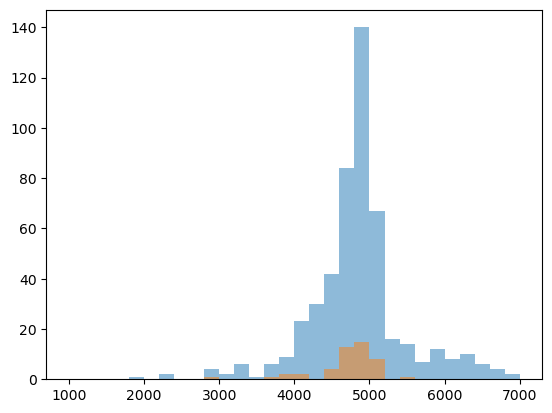

In [190]:

from importlib import import_module
import os
import sys
import argparse
import linecache
import uproot
import vector
import math
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
from tqdm import tqdm  # ✅ 진행률 표시
import glob

vector.register_awkward()

sample = "/data6/Users/achihwan/LRSM_tb_channel/SAMPLEPRODUCTION/WRtoNMutoMuMuTB-HadTop_MWR-5000_MN-2500_13p6TeV/Run3Summer22NanoAODv12_WRtoNMutoMuMuTB-HadTop_MWR-5000_MN-2500_13p6TeV_1.root"
file = uproot.open(sample)
events = file["Events"]

keys = events.keys()
GEN_STATUS_FLAGS = {
    "isPrompt": 0,
    "isDecayedLeptonHadron": 1,
    "isTauDecayProduct": 2,
    "isPromptTauDecayProduct": 3,
    "isDirectTauDecayProduct": 4,
    "isDirectPromptTauDecayProduct": 5,
    "isDirectHadronDecayProduct": 6,
    "isHardProcess": 7,
    "fromHardProcess": 8,
    "isHardProcessTauDecayProduct": 9,
    "isDirectHardProcessTauDecayProduct": 10,
    "fromHardProcessBeforeFSR": 11,
    "isFirstCopy": 12,
    "isLastCopy": 13,
    "isLastCopyBeforeFSR": 14,
}

def decode_gen_status_flags(statusFlags):
    flags = {}
    for name, bit in GEN_STATUS_FLAGS.items():
        flags[name] = ((statusFlags >> bit) & 1).astype(bool)
    return flags
def is_hard_process(statusFlags):
    return ((statusFlags >> 7) & 1).astype(bool)
def muon_status_list():
    muon_mask = (genparticle_pdgid == 13) | (genparticle_pdgid == -13)
    muon_status = genparticle_statusFlags[muon_mask]
    muon_hardprocess_list = []
    for muons in muon_status:
        a = np.array(muons)
        status = is_hard_process(a)
        muon_hardprocess_list.append(status)
    return muon_hardprocess_list
def overlap_removal(target, cleans, cut=0.4, dphi=False):
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return target[mask]
def overlap_itself_removal(target, cleans, cut=0.4, dphi=False):
            mask = ak.ones_like(target["pt"], dtype=bool)
            for clean in cleans:
                pairs = ak.cartesian([target, clean], nested=True) # axis 0 = #event , axis 1 = target , axis 2 = clean
                delta = np.abs(pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
                mask = mask & (ak.min(delta, axis=2) > cut)
            return target[mask]
def find_closest_jet(obj, jets):
    # obj, jets: both are jagged arrays of shape (n_events,), each sublist = Momentum4D
    pairs = ak.cartesian([obj, jets], nested=True)          # shape: (n_events, N_obj, N_jet)
    dr = pairs["0"].deltaR(pairs["1"])                       # same shape
    # 이벤트별로 obj 하나당 가장 작은 ΔR 의 jet index
    closest_idx_per_obj = ak.argmin(dr, axis=2)              # shape = (n_events, N_obj)
    return jets[closest_idx_per_obj]
def Select(inputcoll,etamax,ptmin) :
    output = []
    for obj in inputcoll :
        if abs(obj.eta) < etamax and obj.pt > ptmin : output.append(obj)
    return output 





lhe_pdgid = events["LHEPart_pdgId"].array()
lhe_pt = events["LHEPart_pt"].array()
lhe_eta = events["LHEPart_eta"].array()
lhe_phi = events["LHEPart_phi"].array()
lhe_mass = events["LHEPart_mass"].array()

bottom_mask = (lhe_pdgid == 5) | (lhe_pdgid == -5)
lhe_muon_mask = (lhe_pdgid == 13) | (lhe_pdgid == -13)

lhe_particle  = ak.zip({
    "pt": lhe_pt,
    "eta": lhe_eta,
    "phi": lhe_phi,
    "mass": lhe_mass
}, with_name = "Momentum4D")

lhe_bottoms = lhe_particle[bottom_mask]
lhe_bottoms_eta = lhe_bottoms["eta"][:, 1:2]  
lhe_bottoms_phi = lhe_bottoms["phi"][:, 1:2]
lhe_bottoms_pt = lhe_bottoms["pt"][:, 1:2]  
lhe_bottoms_mass = lhe_bottoms["mass"][:, 1:2]  # bottom quark 1 = WR* mother

lhe_bottom2_eta = lhe_bottoms["eta"][:, 0:1]
lhe_bottom2_phi = lhe_bottoms["phi"][:, 0:1]
lhe_bottom2_pt = lhe_bottoms["pt"][:, 0:1]
lhe_bottom2_mass = lhe_bottoms["mass"][:, 0:1]  # top mother bottom quark

lhe_bottom = ak.zip({
    "eta": lhe_bottoms_eta,
    "phi": lhe_bottoms_phi,
    "pt": lhe_bottoms_pt,
    "mass": lhe_bottoms_mass
}, with_name = "Momentum4D")

lhe_bottom2 = ak.zip({
    "eta": lhe_bottom2_eta,
    "phi": lhe_bottom2_phi,
    "pt": lhe_bottom2_pt,
    "mass": lhe_bottom2_mass
}, with_name = "Momentum4D")

lhe_muons  = lhe_particle[lhe_muon_mask]
lhe_muons_eta = lhe_muons["eta"][:]
lhe_muons_phi = lhe_muons["phi"][:]
lhe_muons_pt = lhe_muons["pt"][:]
lhe_muons_mass = lhe_muons["mass"][:]

n_mother_muon_mass = lhe_muons_mass[:,0:1] 
n_mother_muon_pt = lhe_muons_pt[:,0:1] 
n_mother_muon_eta = lhe_muons_eta[:,0:1]
n_mother_muon_phi = lhe_muons_phi[:,0:1]

wr_mother_muon_mass = lhe_muons_mass[:,1:2]
wr_mother_muon_pt = lhe_muons_pt[:,1:2]
wr_mother_muon_eta = lhe_muons_eta[:,1:2]
wr_mother_muon_phi = lhe_muons_phi[:,1:2]

lhe_muon = ak.zip({
    "pt": lhe_muons_pt,
    "eta": lhe_muons_eta,
    "phi": lhe_muons_phi,
    "mass": lhe_muons_mass
}, with_name = "Momentum4D")

n_mother_muon = ak.zip({
    "pt": n_mother_muon_pt,
    "eta": n_mother_muon_eta,
    "phi": n_mother_muon_phi,
    "mass": n_mother_muon_mass
}, with_name = "Momentum4D")

wr_mother_muon = ak.zip({
    "pt": wr_mother_muon_pt,
    "eta": wr_mother_muon_eta,
    "phi": wr_mother_muon_phi,
    "mass": wr_mother_muon_mass
}, with_name = "Momentum4D")



genparticle_pdgid = events["GenPart_pdgId"].array()
genparticle_pt = events["GenPart_pt"].array()
genparticle_eta = events["GenPart_eta"].array()
genparticle_phi = events["GenPart_phi"].array()
genparticle_mass = events["GenPart_mass"].array()
genparticle_statusFlags = events["GenPart_statusFlags"].array()

top_mask = (genparticle_pdgid == 6) | (genparticle_pdgid == -6)
muon_mask = (genparticle_pdgid == 13) | (genparticle_pdgid == -13)

genparticle  = ak.zip({
    "pt": genparticle_pt,
    "eta": genparticle_eta,
    "phi": genparticle_phi,
    "mass": genparticle_mass
}, with_name = "Momentum4D")



gentops = genparticle[top_mask]
gentops_eta = gentops["eta"][:, 0:1]  
gentops_phi = gentops["phi"][:, 0:1]
gentops_pt = gentops["pt"][:, 0:1]  
gentops_mass = gentops["mass"][:, 0:1]  

genmuons = genparticle[muon_mask]
genmuons_eta = genmuons["eta"][:]
genmuons_phi = genmuons["phi"][:]
genmuons_pt = genmuons["pt"][:]
genmuons_mass = genmuons["mass"][:]

gentop = ak.zip({
    "eta": gentops_eta,
    "phi": gentops_phi,
    "pt": gentops_pt,
    "mass": gentops_mass
}, with_name = "Momentum4D")

genmuon = ak.zip({
    "pt": genmuons_pt,
    "eta": genmuons_eta,
    "phi": genmuons_phi,
    "mass": genmuons_mass
}, with_name = "Momentum4D")

dressed_lepton_pdgid = events["GenDressedLepton_pdgId"].array()
dressed_lepton_pt = events["GenDressedLepton_pt"].array()

genjet_pt = events["GenJet_pt"].array()
genjet_eta = events["GenJet_eta"].array()
genjet_phi = events["GenJet_phi"].array()
genjet_mass = events["GenJet_mass"].array()

genjet = ak.zip({
    "pt": genjet_pt,
    "eta": genjet_eta,
    "phi": genjet_phi,
    "mass": genjet_mass
}, with_name = "Momentum4D")

genjetak8_pt = events["GenJetAK8_pt"].array()
genjetak8_eta = events["GenJetAK8_eta"].array()
genjetak8_phi = events["GenJetAK8_phi"].array()
genjetak8_mass = events["GenJetAK8_mass"].array()

genjetak8 = ak.zip({
    "pt": genjetak8_pt,
    "eta": genjetak8_eta,
    "phi": genjetak8_phi,
    "mass": genjetak8_mass
}, with_name = "Momentum4D")

jet_pt = events["Jet_pt"].array()

muon_pt = events["Muon_pt"].array()


#####################################################
cleaned_Nmother_muon_pt = []
cleaned_WR_mother_muon_pt = []
all_muon_pt = []
cleaned_ak4jet_pt = []
all_ak4jet_pt = []
cleaned_ak8jet_pt =[]
all_ak8jet_pt = []
#####################################################

hardmuons =genmuon[muon_status_list()] ## hard process gen level muons 
nmother_muon = find_closest_jet(n_mother_muon, hardmuons)
wrmother_muon = find_closest_jet(wr_mother_muon, hardmuons)

ak8jet = find_closest_jet(gentop, genjetak8)
ak4jet = find_closest_jet(lhe_bottom, genjet)
topmother_b_ak4jet = find_closest_jet(lhe_bottom2, genjet)
## 1. 뮤온은 자기 자신끼리만 안 겹치면 그대로 사용
overlap_nmother_cleaned = overlap_removal(nmother_muon, [genmuon]) #lepton lepton cleaning
overlap_WR_mother_cleaned = overlap_removal(wrmother_muon, [genmuon]) #lepton lepton cleaning

cleaned_Nmother_muon_pt.append(overlap_nmother_cleaned["pt"])
cleaned_WR_mother_muon_pt.append(overlap_WR_mother_cleaned["pt"])
all_muon_pt.append(hardmuons["pt"])
# 2. b jet은 뮤온이랑만 안 겹치면 그대로 사용 
overlap_ak4_cleaned = overlap_removal(ak4jet, [genmuon, genjet])
    
cleaned_ak4jet_pt.append(overlap_ak4_cleaned["pt"])
all_ak4jet_pt.append(ak4jet["pt"])
# 3. fatjet은 뮤온이랑 b jet이랑 안 겹쳐야 사용

# top mother b 가 안 들어있는 jet들 overlap_itself_removal 사용해서 자기 자신은 지움 
overlap_topmother_b_cleaned = overlap_itself_removal(genjet, [topmother_b_ak4jet])
overlap_fatjet_cleaned_include_signalb = overlap_removal(ak8jet, [genmuon , overlap_topmother_b_cleaned ,genjetak8], cut=0.8)
cleaned_ak8jet_pt.append(overlap_fatjet_cleaned_include_signalb["pt"])
all_ak8jet_pt.append(ak8jet["pt"])

#####################################################
#####################################################

num_cleannmuon =len((ak.flatten(ak.flatten(cleaned_Nmother_muon_pt))))
num_cleanwrmuon = (len((ak.flatten(ak.flatten(cleaned_WR_mother_muon_pt)))))
num_totalsigmuon = (len((ak.flatten(ak.flatten(all_muon_pt)))))
num_cleanak4 = (len((ak.flatten(ak.flatten(cleaned_ak4jet_pt)))))
num_totalsigak4 = (len((ak.flatten(ak.flatten(all_ak4jet_pt)))))
num_cleanak8 = len((ak.flatten(ak.flatten(cleaned_ak8jet_pt))))
num_totalsigak8 = len((ak.flatten(ak.flatten(all_ak8jet_pt))))

print(f"Number of cleaned N mother muons: {num_cleannmuon} , Number of cleaned WR mother muons: {num_cleanwrmuon} , Number of total signal muons: {num_totalsigmuon}")
print(f"Number of cleaned AK4 jets: {num_cleanak4} , Number of total signal AK4 jets: {num_totalsigak4}")
print(f"Number of cleaned AK8 jets (not include signal b): {num_cleanak8} , Number of total signal AK8 jets: {num_totalsigak8}")


nocut_mass = ak4jet + ak8jet + nmother_muon + wrmother_muon
mass = ak.flatten(nocut_mass.mass)
plt.hist(mass, bins=30, range=(1000, 7000), alpha=0.5, label='No Cut Mass Distribution')




overlap_nmother_cleaned_pts = ak.sum(overlap_nmother_cleaned["pt"], axis=1)
overlap_WR_mother_cleaned_pts = ak.sum(overlap_WR_mother_cleaned["pt"], axis=1)
overlap_ak4_cleaned_pts = ak.sum(overlap_ak4_cleaned["pt"], axis=1)
overlap_fatjet_cleaned_include_signalb_pts = ak.sum(overlap_fatjet_cleaned_include_signalb["pt"], axis=1)


leftmask = (overlap_nmother_cleaned_pts > 0.0) & (overlap_WR_mother_cleaned_pts > 0.0) & (overlap_ak4_cleaned_pts > 0.0) & (overlap_fatjet_cleaned_include_signalb_pts > 0.0)

overlap_nmother_cleaned = overlap_nmother_cleaned[leftmask]
overlap_WR_mother_cleaned = overlap_WR_mother_cleaned[leftmask]
overlap_ak4_cleaned = overlap_ak4_cleaned[leftmask]
overlap_fatjet_cleaned_include_signalb = overlap_fatjet_cleaned_include_signalb[leftmask]

combined_p4 = overlap_nmother_cleaned + overlap_WR_mother_cleaned + overlap_ak4_cleaned + overlap_fatjet_cleaned_include_signalb
plt.hist(combined_p4.mass, bins=30, range=(1000, 7000), alpha=0.5, label='Cleaned Mass Distribution')
print(len(combined_p4.mass))

### pt 순서대로 골랐을 때 (gen)

lhe bottom [[1.14e+03], [972], [137], [1.08e+03], [391], ..., [986], [143], [480], [207]]
lhe bottom from top [[80.5], [969], [324], [176], [288], ..., [479], [83.7], [254], [585], [408]]
lhe muon [[998, 1.53e+03], [372, 1.24e+03], [525, ...], ..., [518, 840], [793, 301]]
all genjet [1.39e+03, 1.25e+03, 926, 394, 108, 52, 48.8, 15.9]
signal b jet [[1.14e+03], [926], [103], [960], [349], ..., [981], [165], [486], [11.2]]
all gen muon [1.52e+03, 1.52e+03, 1e+03, 5.31, 5.2]
hard process muon [[1.52e+03, 1e+03], [1.27e+03, 370], [...], ..., [...], [902, 489], [320, 802]]
gen top [[186], [1.4e+03], [1.71e+03], [986], ..., [279], [896], [1.48e+03], [1.17e+03]]
[108]


/tmp/ipykernel_1223717/1568239669.py:52: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  a = np.array(muons)


431
firstmuon cleaned [[1.52e+03], [], [1.46e+03], [1.9e+03], ..., [400], [692], [], [320]]
second muon cleaned [[1e+03], [370], [530], [469], [900], ..., [616], [874], [664], [], [802]]
bjet cleaned [[1.14e+03], [1.39e+03], [83.5], [960], ..., [874], [1.37e+03], [1.08e+03]]
255
[[1.14e+03, 108], [1.51e+03], [], ..., [...], [1.39e+03, 599, 308], [1.16e+03]]
[108, 52, 48.8, 15.9]


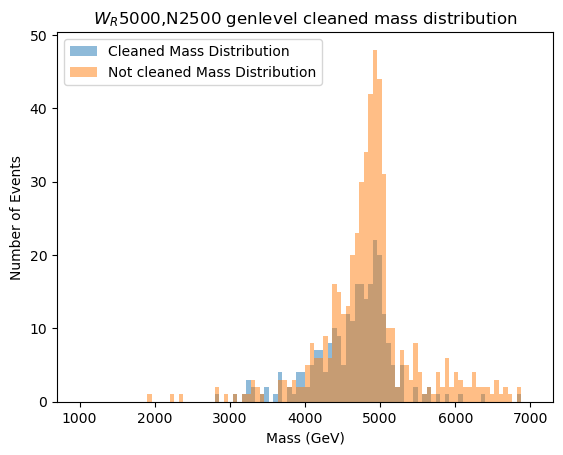

In [ ]:

print("lhe bottom",lhe_bottom["pt"])
print("lhe bottom from top",lhe_bottom2["pt"])
print("lhe muon",lhe_muon["pt"])
print("all genjet",genjet["pt"][1])
print("signal b jet",ak4jet["pt"])
print("all gen muon",genmuon["pt"][0])
print("hard process muon",genmuon[muon_status_list()]["pt"])
print("gen top",gentop["pt"])
print(ak8jet["pt"][0])


### 어차피 뮤온 중에서는 제일 큰거 두개가 거의 무조건 시그널임 
first_muon = genmuon[muon_status_list()][:, 0:1]  # 첫 번째 뮤온
second_muon = genmuon[muon_status_list()][:, 1:2]  # 두 번째 뮤온

#### 겹치는지 확인 
first_muon_cleaned = overlap_removal(first_muon, [genmuon], cut=0.4)
second_muon_cleaned = overlap_removal(second_muon, [genmuon], cut=0.4)
print( len(ak.flatten(first_muon_cleaned["pt"])))
print("firstmuon cleaned",first_muon_cleaned["pt"])
print("second muon cleaned",second_muon_cleaned["pt"])
### ak4 중에서 렙톤 근처에 없고 근처에 ak4없는것 중에 제일 큰 pt
signalb_cleaned = overlap_removal(genjet, [genmuon, genjet], cut=0.4)
signalb_cleaned_sorted = signalb_cleaned[ak.argsort(signalb_cleaned["pt"], axis = 1,ascending=False)]
signalb_cleaend_sorted = signalb_cleaned_sorted[:, 0:1]  # 가장 큰 pt를 가진 jet만 선택
print("bjet cleaned",signalb_cleaend_sorted["pt"])
### ak8 중에서 렙톤 근처에 없고 위에서 뽑은 ak4가 안 들어있는거 
signaltop_cleaned = overlap_removal(genjetak8, [genmuon, genjetak8 , signalb_cleaend_sorted], cut=0.8)
signaltop_cleaned_sorted = signaltop_cleaned[ak.argsort(signaltop_cleaned["pt"], axis = 1, ascending=False)]
signaltop_cleaned_sorted = signaltop_cleaned_sorted[:, 0:1]

####빈 이벤트 빼고 연산하는 마스크 만들기 
first_muon_cleaned_pt = ak.sum(first_muon_cleaned["pt"], axis=1)
second_muon_cleaned_pt = ak.sum(second_muon_cleaned["pt"], axis=1)
signalb_cleaned_pt = ak.sum(signalb_cleaend_sorted["pt"], axis=1)
signaltop_cleaned_pt = ak.sum(signaltop_cleaned_sorted["pt"], axis=1)  

leftmask = (first_muon_cleaned_pt > 0.0) & (second_muon_cleaned_pt > 0.0) & (signalb_cleaned_pt > 0.0) & (signaltop_cleaned_pt > 0.0)

first_muon_cleaned = first_muon_cleaned[leftmask]
second_muon_cleaned = second_muon_cleaned[leftmask]
signalb_cleaend_sorted = signalb_cleaend_sorted[leftmask]
signaltop_cleaned_sorted = signaltop_cleaned_sorted[leftmask]

combined_p4 = first_muon_cleaned + second_muon_cleaned + signalb_cleaend_sorted + signaltop_cleaned_sorted
plt.hist(combined_p4.mass, bins=100, range=(1000, 7000), alpha=0.5, label='Cleaned Mass Distribution')
print(len(combined_p4.mass))


nocut_mass = ak4jet + ak8jet + first_muon + second_muon
mass = ak.flatten(nocut_mass.mass)
plt.hist(mass, bins=100, range=(1000, 7000), alpha=0.5, label='Not cleaned Mass Distribution')

plt.legend()
plt.xlabel('Mass (GeV)')
plt.ylabel('Number of Events')
plt.title("$W_{R}$5000,N2500 genlevel cleaned mass distribution")



############# 뮤온 , fatjet , bjet 순서인 경우 

## 뮤온 클리닝은 동일 

## fatjet 주변에 fatjet 없고 , 뮤온 없어야 함 
signaltop_cleaned2 = overlap_removal(genjetak8, [genmuon, genjetak8], cut=0.8)
print(signaltop_cleaned2["pt"]) ## 이거 b jet 들어오긴한데 top tagger로 없앨 수 있을 거 같은데 
signalb_cleaned2 = overlap_removal(genjet, [genmuon, genjetak8, genjet], cut=0.4)
print(signalb_cleaned2["pt"][1]) ## 이거 b jet 들어오긴한데 top tagger로 없앨 수 있을 거 같은데 그래도 ak8가 근처에 있으면 사라지니까 다 없어짐 

### cleaning + cut adjusting 